In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [2]:
products_data=pd.read_csv('Preprocessed_data.csv')
products_data

,Title,category
0,campbell natural light italianstyle vegetable ...,Grocery and Gourmet Food
1,hawaiian sun strawberry guava jam large,Grocery and Gourmet Food
2,beef flat iron natural angus choice xoz,Grocery and Gourmet Food
3,k coffee company sierra madre central american...,Grocery and Gourmet Food
4,cafix coffee substitute ounce per case,Grocery and Gourmet Food
...,...,...
79995,pleaser woman kissuvwsanw platform dress sandal,Clothing Shoes and Jewelry
79996,mordenmiss woman autumn casual dress travel ho...,Clothing Shoes and Jewelry
79997,friendshop sheer back slim clubwear cocktail h...,Clothing Shoes and Jewelry
79998,seya twotone modern jewelry box organizer,Clothing Shoes and Jewelry


In [3]:
# Shuffling a Pandas dataframe with .shuffle()
products_data = products_data.sample(frac=1).reset_index()
products_data

,index,Title,category
0,27274,head case design sun wood art protective snapo...,Electronics
1,62557,ich esse gerne obst und gemuse love eat fruit ...,Books
2,71058,kung fu adult youth cotton ringer tshirt color,Clothing Shoes and Jewelry
3,63586,lovis corinth california study history art,Books
4,53967,sequin beaded trim yard osb,Arts Crafts and Sewing
...,...,...,...
79995,12896,ultra pet clumping crystal cat litter white cr...,Others
79996,62012,technical bulletin dianetics scientology vol vi,Books
79997,13001,willow tree musical courage,Others
79998,43872,mini furniture flower sofa couch cushion kit s...,Beauty


# Rendre label numerique

In [5]:
l=[]
for text in products_data["category"].unique():
    l.append(text)


y = []

for text in products_data["category"]:
    for j in range(8):
        if text==l[j]:
            y.append(j)
    
y = np.asarray(y)

yy = pd.Series(y)
yy

0        0
1        1
2        2
3        1
4        3
        ..
79995    4
79996    1
79997    4
79998    7
79999    0
Length: 80000, dtype: int64

# Extracting Features From TextData using TF-IDF

In [6]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

In [7]:
textList=[]
for text in products_data["Title"]:
    textList.append(text)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#preparing x for ANN
tfidv = TfidfVectorizer()
x = tfidv.fit_transform(textList)
x.sort_indices()


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

# Linear Support Vector Classification

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Test of 4 models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, x, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
print('model_name')
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
LinearSVC
MultinomialNB
LogisticRegression
model_name


In [11]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.895575
LogisticRegression        0.869275
MultinomialNB             0.856875
RandomForestClassifier    0.649850
Name: accuracy, dtype: float64

In [12]:
# test of Linear svc only

In [19]:
linear_svc = LinearSVC()
classifier = linear_svc.fit(x_train,y_train)

In [20]:
y_pred = classifier.predict(x_test)

In [21]:
from sklearn.metrics import accuracy_score
print("Number of features is", x_train.shape[1])
print("Test set accuracy of SVC Classifier is {}".format(round(accuracy_score(y_pred,y_test)*100,2)))

Number of features is 59088
Test set accuracy of SVC Classifier is 88.55


In [22]:
import pickle
pickle.dump(classifier, open('svc-totalF-88.55.pkl', 'wb'))

In [25]:
loaded_model = pickle.load(open('svc-totalF-88.55.pkl', 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.885530303030303


# After feature selection

In [26]:
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import accuracy_score
import pickle
from sklearn.neural_network import MLPClassifier


def select_features_CH2(p,x_train, y_train, x_test):
    CH2 = SelectPercentile(chi2, percentile=p)
    CH2.fit(x_train, y_train)
    x_train_CH2 = CH2.transform(x_train)
    x_test_CH2 = CH2.transform(x_test)
    return x_train_CH2, x_test_CH2, CH2

accuracies = {}

for p in range(5, 105, 5):
    print("Percentage of features is:", p)
    x_train_CH2, x_test_CH2, CH2 = select_features_CH2(p,x_train, y_train, x_test)
    n = x_train_CH2.shape[1]
    print("Number of features is:", n)
    classifier = LinearSVC().fit(x_train_CH2,y_train)
    classifier.fit(x_train_CH2, y_train)
    y_pred = classifier.predict(x_test_CH2)
    accuracy = round(accuracy_score(y_pred,y_test)*100,2)
    print("Accuracy for the {} best features is: {}%".format(n, accuracy))
    ss = "LSVC_p-"+str(p)+"_n-"+str(n)+"_acc-"+str(accuracy)+".pickle"
    pickle.dump(classifier, open(ss, "wb"))
    accuracies[p] = [n, accuracy, ss]

Percentage of features is: 5
Number of features is: 2955
Accuracy for the 2955 best features is: 83.62%
Percentage of features is: 10
Number of features is: 5908
Accuracy for the 5908 best features is: 85.61%
Percentage of features is: 15
Number of features is: 8864
Accuracy for the 8864 best features is: 86.66%
Percentage of features is: 20
Number of features is: 11818
Accuracy for the 11818 best features is: 87.12%
Percentage of features is: 25
Number of features is: 14772
Accuracy for the 14772 best features is: 87.55%
Percentage of features is: 30
Number of features is: 17727
Accuracy for the 17727 best features is: 87.81%
Percentage of features is: 35
Number of features is: 20681
Accuracy for the 20681 best features is: 87.9%
Percentage of features is: 40
Number of features is: 23635
Accuracy for the 23635 best features is: 88.05%
Percentage of features is: 45
Number of features is: 26589
Accuracy for the 26589 best features is: 88.16%
Percentage of features is: 50
Number of featu

In [28]:
# Load model already saved
import pickle

classifier = pickle.load(open("LSVC_p-85_n-50224_acc-88.55.pickle","rb"))
CH2 = SelectPercentile(chi2, percentile=85)
CH2.fit(x_train, y_train)
x_test_CH2 = CH2.transform(x_test)
y_pred = classifier.predict(x_test_CH2)

print("The best accuracy after feature selection is" ,round(accuracy_score(y_pred,y_test)*100,2))

The best accuracy after feature selection is 88.55


In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

#Function to plot confusion matrix for the passed model and the data
def plot_confusion_matrix(model, X_test, y_test):
    
    classes = products_data.category.unique()
    # use model to do the prediction
    y_pred = model.predict(x_test_CH2)
    # compute confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    # plot confusion matrix
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)

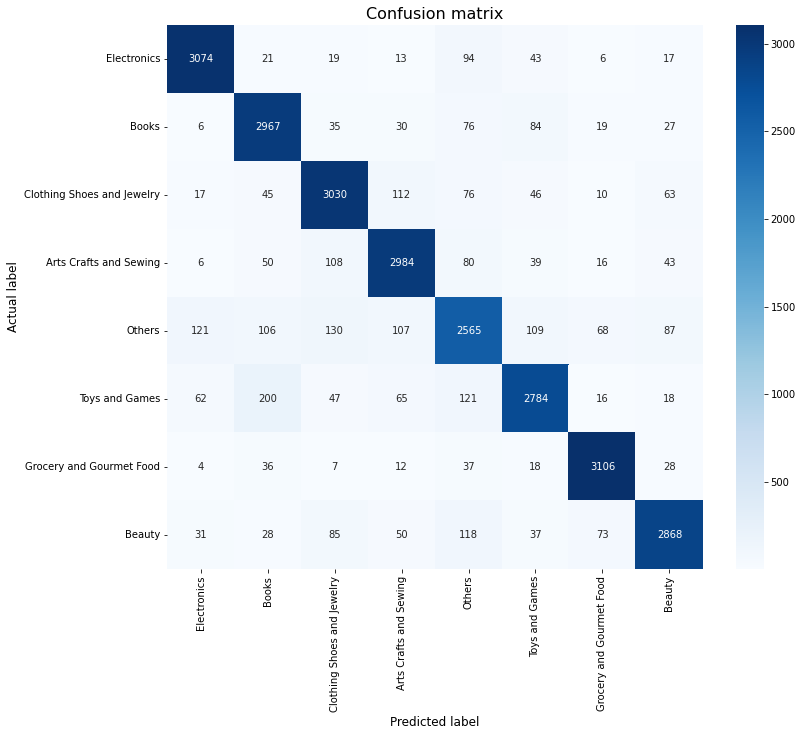

In [30]:
plot_confusion_matrix(classifier, x_test, y_test)

# True Positive, True Negative, False Positive and False Negative

In [45]:
cm=confusion_matrix(y_test,y_pred)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('True positive rate',TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('True negative rate',TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False positive rate',FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate',FNR)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('ACC',ACC)
print('**********************************')
acc = np.diag(cm).sum() / cm.sum()
print('acc',acc)


True positive rate [0.93519927 0.91461159 0.89143866 0.89717378 0.77892499 0.84032599
 0.95628079 0.87173252]
True negative rate [0.98931337 0.97901192 0.98126168 0.9831412  0.97394729 0.98371378
 0.99101589 0.98775422]
False positive rate [0.01068663 0.02098808 0.01873832 0.0168588  0.02605271 0.01628622
 0.00898411 0.01224578]
False negative rate [0.06480073 0.08538841 0.10856134 0.10282622 0.22107501 0.15967401
 0.04371921 0.12826748]
ACC [0.98257576 0.97109848 0.96969697 0.97231061 0.94962121 0.9657197
 0.98674242 0.97329545]
**********************************
acc 0.885530303030303
